In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Activation, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorboard
import numpy as np
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(device, True)
    except:
        pass

logging.getLogger().setLevel(logging.INFO)

In [3]:
(x_train,y_ultra_train, y_super_train, y_sub_train), (x_test, y_ultra_test, y_super_test, y_sub_test) = pickle.load(open("car196_train_val.pickle", "rb" ))
y_ultra_train, y_super_train, y_sub_train = to_categorical(y_ultra_train), to_categorical(y_super_train), to_categorical(y_sub_train)
y_ultra_test, y_super_test, y_sub_test = to_categorical(y_ultra_test), to_categorical(y_super_test), to_categorical(y_sub_test)

In [4]:
def get_labels(idx, level = 'super'):
    labels = {
        'super' : ['Chevrolet', 'Hyundai', 'Lamborghini', 'Nissan', 'Mazda', 'GMC', 'FIAT', 'Honda', 'Bentley', 'Fisker', 'Audi', 'Lincoln', 'Volkswagen', 'Spyker', 'Bugatti', 'Chrysler', 'Infiniti', 'Rolls-Royce', 'Mercedes-Benz', 
                   'Plymouth', 'smart', 'Isuzu', 'Ram', 'Maybach', 'Eagle', 'HUMMER', 'Cadillac', 'Geo', 'Volvo', 'Suzuki', 'Jeep', 'Land_Rover', 'Scion', 'Dodge', 'Ford', 'Jaguar', 'BMW', 'Aston_Martin', 'Buick', 'McLaren', 
                   'MINI_Cooper', 'Mitsubishi', 'Tesla', 'Toyota', 'Acura', 'Ferrari', 'Porsche', 'Daewoo'],
        'sub' : ['Veloster', 'Caliber', '500', 'F_450_Super_Duty', 'Range_Rover', 'Traverse', 'RS_4', 'Continental_Flying_Spur', 'TL_TypeS', 'Lancer', '240', 'fortwo', 'Accord', 'Diablo', 'Dakota', 'Sonic', 'C-Class', 'Focus', '300_SRT8',
                 'S4', 'Veracruz', 'Sprinter', 'TT', 'Silverado_1500', 'QX56', 'S6', 'Leaf', 'Corvette', '100', 'Silverado_2500HD', 'Continental_GT', 'NV_Passenger', 'Mulsanne', '458_Italia', 'Charger', 'Compass', 'Reventon', 'Mustang', 
                 'Acadia', 'Nubira', 'Cobalt_SS', 'Aventador', 'HHR_SS', '240SX', 'Kizashi', 'RL', '1_Series', 'XC90', 'Corvette_Ron_Fellows_Edition_Z06', '4Runner', 'Accent', 'Tucson', 'Caravan', 'Juke', 'Savana', 'Azera', 'Beetle', 'E-Class',
                 'Genesis', 'Camry', 'Continental_Supersports_Conv', 'Canyon', 'Silverado_1500_Classic', 'M6', 'Express', 'Crossfire', 'Arnage', 'Charger_SRT8', 'H3T', 'Grand_Cherokee', 'Landaulet', 'MP4-12C', 'Ranger', 'Ascender', 'C8', 'Journey',
                 'Wrangler', 'TrailBlazer_SS', 'SRX', 'Elantra', 'V8_Vantage', 'SL-Class', 'Golf', 'Sonata', 'Magnum', 'Malibu', 'CTS-V', 'Malibu_Hybrid', 'Durango', '500_Abarth', 'Tahoe_Hybrid', 'Edge', 'E-Series', 'Enclave', 'California', 
                 '6_Series', 'Integra_Type_R', 'Veyron_16_4', 'Escalade_EXT', 'Patriot', 'FF', 'Odyssey', 'Model_S', 'Panamera', 'Camaro', 'Freestar', '3_Series', 'Aerio', 'LR2', 'Impala', 'S5', 'Regal_GS', 'G_Coupe', 'TSX', 'XK_XKR', 'TT_RS',
                 'Corvette_ZR1', 'Karma', 'Roadster', 'Phantom', 'V8', 'Silverado_1500_Hybrid', 'Talon', 'SX4', 'Town_and_Country', 'Expedition_EL', 'Phantom_Drophead_Coupe', 'X6', 'CV_Van', 'Verano', 'Rainier', 'X5', 'Monte_Carlo', 'Corolla', 
                 'Avalanche', 'F-150', 'Aspen', 'Metro', 'Town_Car', 'ZDX', 'A5', 'Yukon_Hybrid', 'Gallardo_LP_Superleggera', 'S-Class', 'X3', 'M3', 'Sonata_Hybrid', 'Liberty', 'ActiveHybrid_5', 'Ram_Pickup_3500', 'Sequoia', 'xD', 'Ghost', 'Challenger_SRT8',
                 'Fiesta', 'Elantra_Touring', 'Tribute', 'Terrain', 'TL', 'H2_SUT', 'Z4', 'M5', 'Sebring', 'Neon', 'R8', 'GT', 'TTS', '300-Class', 'Virage', 'C30', 'Santa_Fe', 'General', 'PT_Cruiser'],
        'ultra' : ['Minivan', 'Wagon', 'SUV', 'Van', 'Coupe', 'Hatchback', 'Cab', 'Sedan', 'Convertible']
    }
    return labels[level][idx]

v_get_labels = np.vectorize(get_labels)

In [5]:
def plot_sample_images(inputs, v_label_func, top_n = 14, n_col = 7):
    (images, ultra_labels_idx, super_labels_idx, sub_labels_idx) = inputs
    assert len(images) == len(ultra_labels_idx) == len(super_labels_idx) == len(sub_labels_idx)
    ultra_labels, super_labels, sub_labels = v_label_func(np.argmax(ultra_labels_idx, axis = 1), 'ultra'), v_label_func(np.argmax(super_labels_idx, axis = 1), 'super'),  v_label_func(np.argmax(sub_labels_idx, axis = 1), 'sub')
    top_n = top_n if top_n < len(images) else len(images)
    n_row = int(top_n/n_col)
    images = images[:top_n]
    figsize = (4 * n_col, 3.5 * n_row)
    fig, axes = plt.subplots(n_row, n_col, figsize = figsize)
    for idx, image in enumerate(images):
        ax = axes[idx // n_col, idx % n_col]
        ax.imshow(image)
        ax.set_title(f"{ultra_labels[idx]} - {super_labels[idx]} - {sub_labels[idx]}")
    plt.tight_layout()
    plt.show()

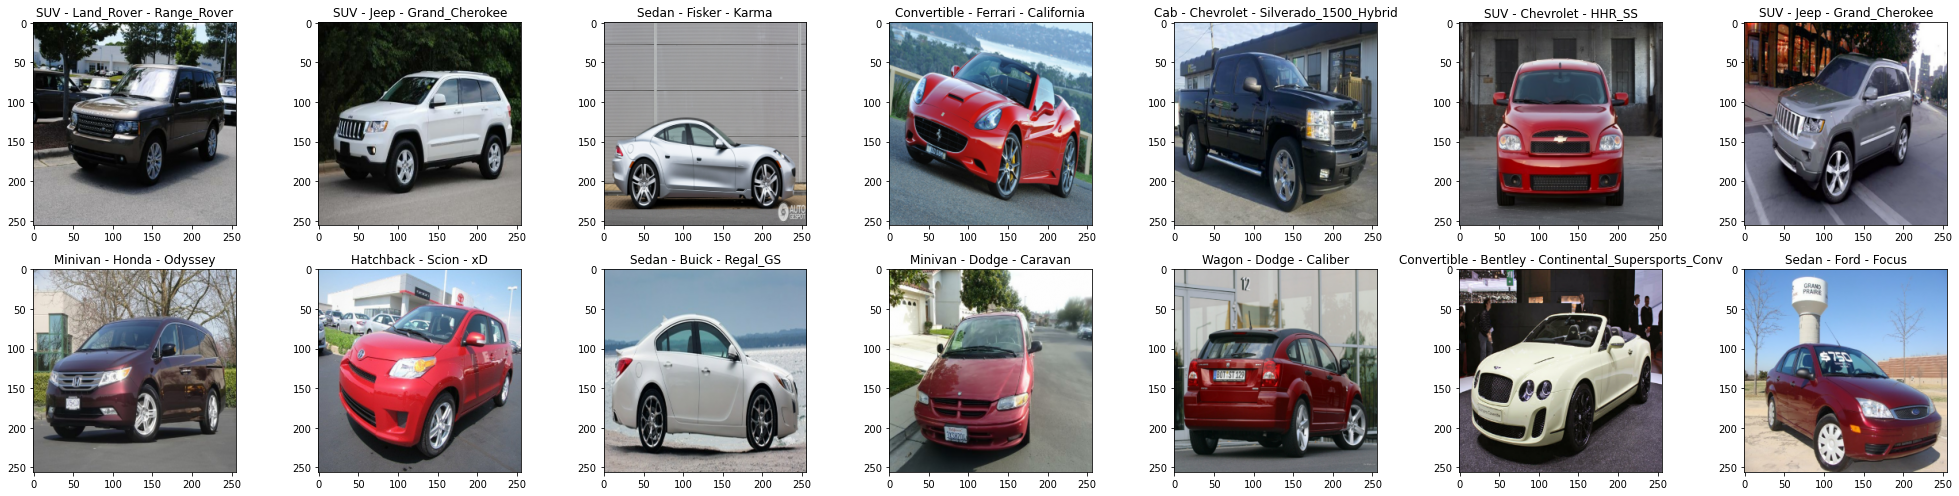

In [6]:
plot_sample_images((x_train,y_ultra_train, y_super_train, y_sub_train), v_get_labels)

In [7]:
def gen_hierarchy(super_label, sub_label, use_argmax = False):
    combined_labels = np.stack((np.argmax(super_label, axis = 1), np.argmax(sub_label, axis = 1)), axis = 1)
    unique_combinations = np.unique(combined_labels, axis = 0)
    hierarchy={}
    for combination in unique_combinations:
        super_class, sub_class = combination
        if super_class in hierarchy.keys():
            hierarchy[super_class].append(sub_class)
        else:
            hierarchy[super_class] = [sub_class]
    return hierarchy

In [8]:
def dense_block(units, dropout=0.3, activation='relu', name='default_fc1', enable_dropout=True, initializer = tf.keras.initializers.GlorotNormal()):
    def layer_wrapper(inp):
        x = Dense(units, kernel_initializer = initializer, name=name)(inp)
#         x = BatchNormalization(name='{}_bn'.format(name))(x)
        x = Activation(activation, name='{}_act'.format(name))(x)
        if enable_dropout:
            x = Dropout(dropout, name='{}_dropout'.format(name))(x)
        return x
    return layer_wrapper


def create_classifier(base_layer, n_classes, fc_dropout=0.3, activation='relu', class_type = 'default', nodes = 64):
    
    x = Flatten(name=f'{class_type}_flatten')(base_layer.output)
    x = Dropout(0.5, name=f'{class_type}_dropout')(x)
    
    # FC Layers
    x = dense_block(nodes * 8, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc1')(x)
    
    # Classification block    
    x = Dense(n_classes, activation='softmax', name=f'{class_type}_output')(x)
    
    return x

In [9]:
def create_model(n_classes, input_shape, init_lr=1e-4, plot = False):
    base_layer = tf.keras.applications.ResNet50V2(
                                                    include_top=False,
                                                    weights="imagenet",
                                                    input_shape=input_shape                                                    
                                                )
    
    branch = create_classifier(base_layer, n_classes)
    
    model = keras.Model(inputs=base_layer.input,
             outputs = branch,
             name="car196")
    
    lr_decay = 1e-6
    
    opt = keras.optimizers.Adam(lr=init_lr, decay=lr_decay)
    
    k = int(n_classes / 10) if int(n_classes / 10)>2 else 2

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=k)]
    )
    
    if plot:
        fig = tf.keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=60)
        display(fig)
        
    return model

def reset_keras(model):
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del model
    except:
        pass

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

def train_and_pred(model, x_train, y_train, x_test, y_test):
    batch_size = 36
    epochs = 50
        
    train_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )
    train = train_gen.flow(x_train, y_train, batch_size)
    train_step = len(x_train)/batch_size
    
    model.fit(
        train, 
        steps_per_epoch = train_step,
        validation_data=(x_test, y_test),
        epochs=epochs,
        workers = 40,
        max_queue_size = 80,
    )
    
    result = model.predict(x_test, use_multiprocessing=True)
    reset_keras(model)
    return result

In [10]:
n_ultraclasses = 9
input_shape = x_train[0].shape
yhat_ultra_test = train_and_pred(create_model(n_ultraclasses, input_shape), x_train, y_ultra_train, x_test, y_ultra_test)

Epoch 1/50
360/360 [==============================] - 110s 280ms/step - loss: 2.3259 - accuracy: 0.3736 - top_k_categorical_accuracy: 0.5837 - val_loss: 0.8440 - val_accuracy: 0.6891 - val_top_k_categorical_accuracy: 0.8713
Epoch 2/50
360/360 [==============================] - 97s 266ms/step - loss: 0.9593 - accuracy: 0.6493 - top_k_categorical_accuracy: 0.8394 - val_loss: 0.6607 - val_accuracy: 0.7559 - val_top_k_categorical_accuracy: 0.9067
Epoch 3/50
360/360 [==============================] - 96s 262ms/step - loss: 0.6917 - accuracy: 0.7528 - top_k_categorical_accuracy: 0.9103 - val_loss: 0.5947 - val_accuracy: 0.7935 - val_top_k_categorical_accuracy: 0.9263
Epoch 4/50
360/360 [==============================] - 95s 260ms/step - loss: 0.5510 - accuracy: 0.8044 - top_k_categorical_accuracy: 0.9360 - val_loss: 0.4608 - val_accuracy: 0.8402 - val_top_k_categorical_accuracy: 0.9543
Epoch 5/50
360/360 [==============================] - 95s 260ms/step - loss: 0.4491 - accuracy: 0.8449 - to

In [11]:
n_superclasses = 48
yhat_super_test = train_and_pred(create_model(n_superclasses, input_shape), x_train, y_super_train, x_test, y_super_test)

Epoch 1/50
360/360 [==============================] - 102s 263ms/step - loss: 4.0097 - accuracy: 0.1317 - top_k_categorical_accuracy: 0.3261 - val_loss: 2.4027 - val_accuracy: 0.3775 - val_top_k_categorical_accuracy: 0.6458
Epoch 2/50
360/360 [==============================] - 93s 255ms/step - loss: 2.3572 - accuracy: 0.3801 - top_k_categorical_accuracy: 0.6363 - val_loss: 1.5315 - val_accuracy: 0.5709 - val_top_k_categorical_accuracy: 0.8004
Epoch 3/50
360/360 [==============================] - 93s 255ms/step - loss: 1.6533 - accuracy: 0.5412 - top_k_categorical_accuracy: 0.7772 - val_loss: 1.2169 - val_accuracy: 0.6580 - val_top_k_categorical_accuracy: 0.8638
Epoch 4/50
360/360 [==============================] - 93s 255ms/step - loss: 1.2380 - accuracy: 0.6475 - top_k_categorical_accuracy: 0.8614 - val_loss: 1.0835 - val_accuracy: 0.6968 - val_top_k_categorical_accuracy: 0.8868
Epoch 5/50
360/360 [==============================] - 93s 255ms/step - loss: 0.9761 - accuracy: 0.7208 - to

In [12]:
n_subclasses = 173
yhat_sub_test = train_and_pred(create_model(n_subclasses, input_shape), x_train, y_sub_train, x_test, y_sub_test)

Epoch 1/50
360/360 [==============================] - 102s 263ms/step - loss: 5.6270 - accuracy: 0.0124 - top_k_categorical_accuracy: 0.1469 - val_loss: 4.6833 - val_accuracy: 0.0669 - val_top_k_categorical_accuracy: 0.3464
Epoch 2/50
360/360 [==============================] - 93s 256ms/step - loss: 4.6604 - accuracy: 0.0640 - top_k_categorical_accuracy: 0.3592 - val_loss: 3.5180 - val_accuracy: 0.2074 - val_top_k_categorical_accuracy: 0.6866
Epoch 3/50
360/360 [==============================] - 93s 256ms/step - loss: 3.6500 - accuracy: 0.1848 - top_k_categorical_accuracy: 0.6441 - val_loss: 2.6030 - val_accuracy: 0.3585 - val_top_k_categorical_accuracy: 0.8396
Epoch 4/50
360/360 [==============================] - 93s 256ms/step - loss: 2.6971 - accuracy: 0.3399 - top_k_categorical_accuracy: 0.8239 - val_loss: 1.7693 - val_accuracy: 0.5305 - val_top_k_categorical_accuracy: 0.9356
Epoch 5/50
360/360 [==============================] - 93s 256ms/step - loss: 2.0439 - accuracy: 0.4668 - to

In [13]:
y_ultra, yhat_ultra = v_get_labels(np.argmax(y_ultra_test, axis=1), 'ultra'), v_get_labels(np.argmax(yhat_ultra_test, axis=1), 'ultra')
y_super, yhat_super = v_get_labels(np.argmax(y_super_test, axis=1), 'super'), v_get_labels(np.argmax(yhat_super_test, axis=1), 'super')
y_sub, yhat_sub = v_get_labels(np.argmax(y_sub_test, axis=1),'sub'), v_get_labels(np.argmax(yhat_sub_test, axis=1),'sub')

In [14]:
pd.crosstab(y_ultra, yhat_ultra, rownames=['Actual'], colnames=['Pred'])

Pred,Cab,Convertible,Coupe,Hatchback,Minivan,SUV,Sedan,Van,Wagon
Actual,,,,,,,,,
Cab,292,0,1,0,0,6,1,0,0
Convertible,0,388,42,3,0,4,14,1,0
Coupe,1,13,465,5,0,4,37,0,0
Hatchback,0,4,10,181,1,3,7,0,3
Minivan,0,0,0,0,95,1,2,0,0
SUV,3,1,1,2,3,566,4,0,0
Sedan,2,5,20,5,0,3,801,0,1
Van,0,0,0,0,0,0,0,117,0
Wagon,1,0,3,1,0,4,6,0,83


In [15]:
pd.crosstab(y_super, yhat_super, rownames=['Actual'], colnames=['Pred'])

Pred,Acura,Aston_Martin,Audi,BMW,Bentley,Bugatti,Buick,Cadillac,Chevrolet,Chrysler,...,Ram,Rolls-Royce,Scion,Spyker,Suzuki,Tesla,Toyota,Volkswagen,Volvo,smart
Actual,,,,,,,,,,,,,,,,,,,,,
Acura,83,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
Aston_Martin,1,46,1,4,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
Audi,3,1,203,2,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2,0,0
BMW,1,1,2,219,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
Bentley,0,0,1,2,88,0,0,1,3,0,...,0,0,0,0,1,0,0,0,0,0
Bugatti,1,0,0,0,0,26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Buick,0,0,0,0,0,0,60,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Cadillac,0,0,0,0,0,0,0,40,0,0,...,0,0,0,0,0,0,0,0,0,0
Chevrolet,1,0,1,0,0,0,2,1,329,1,...,0,0,0,0,0,0,0,0,1,0


In [16]:
pd.crosstab(y_sub, yhat_sub, rownames=['Actual'], colnames=['Pred'])

Pred,100,1_Series,240,240SX,300-Class,300_SRT8,3_Series,458_Italia,4Runner,500,...,X3,X5,X6,XC90,XK_XKR,Yukon_Hybrid,Z4,ZDX,fortwo,xD
Actual,,,,,,,,,,,,,,,,,,,,,
100,28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1_Series,0,27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
240,1,0,22,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
240SX,0,0,0,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
300-Class,0,0,0,0,17,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yukon_Hybrid,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,13,0,0,0,0
Z4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,0,0,0
ZDX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11,0,0


In [17]:
def calculate_hiearchy_mismatch(super_labels, sub_labels, hierarchy):
    mismatch = 0
    assert len(super_labels) == len(sub_labels)
    for idx, super_label in enumerate(super_labels):
        if sub_labels[idx] not in hierarchy[super_label]:
            mismatch += 1
    return mismatch

In [18]:
n_rows = len(x_test)
error_rate_ultra = sum(y_ultra != yhat_ultra) / n_rows
error_rate_super = sum(y_super != yhat_super) / n_rows
error_rate_sub = sum(y_sub != yhat_sub) / n_rows

mismatch_rate = 0

hierarchy = gen_hierarchy(y_ultra_train, y_sub_train)
n_mismatch = calculate_hiearchy_mismatch(np.argmax(yhat_ultra_test, axis=1), np.argmax(yhat_sub_test, axis=1), hierarchy)
mismatch_rate += n_mismatch / n_rows

hierarchy = gen_hierarchy(y_ultra_train, y_super_train)
n_mismatch = calculate_hiearchy_mismatch(np.argmax(yhat_ultra_test, axis=1), np.argmax(yhat_super_test, axis=1), hierarchy)
mismatch_rate += n_mismatch / n_rows

hierarchy = gen_hierarchy(y_super_train, y_sub_train)
n_mismatch = calculate_hiearchy_mismatch(np.argmax(yhat_super_test, axis=1), np.argmax(yhat_sub_test, axis=1), hierarchy)
mismatch_rate += n_mismatch / n_rows

mismatch_rate /= 3

print(f"Ultra Class Error Rate: {error_rate_ultra}\nSuper Class Error Rate: {error_rate_super}\nSub Class Error Rate: {error_rate_sub}\nAverage Mismatch Rate: {mismatch_rate}")

Ultra Class Error Rate: 0.0708955223880597
Super Class Error Rate: 0.0929726368159204
Sub Class Error Rate: 0.14769900497512436
Average Mismatch Rate: 0.09297263681592038
